![Funcional Health Tech](logo.png "Logo")

**COVID19 - Análise do Surto Brasileiro**

# Análise Exploratória com Inferência de Efeito Causal a partir de SRAGs

Neste *notebook* analisamos os dados reportados de casos de Síntrome Respiratória Aguda Grave (SRAG), sob a hipótese de que desse número se possa estimar uma boa aproximação do número real da incidência de COVID-19, já que supõe-se que a epidemia esteja subnotificada. A inferência de efeito causal é feita de modo rudimentar, empregando-se a versão Python da biblioteca [CausalImpact](https://github.com/dafiti/causalimpact).

Os dados analisados foram extraídos do sistema [Info Gripe da Fiocruz](http://info.gripe.fiocruz.br/), tais como disponibilizados oficialmente no [repositório da Fiocruz](https://gitlab.procc.fiocruz.br/mave/repo/-/tree/master/Dados/InfoGripe). 

Obs.: anteriormente havíamos empregado um [*scrapper* não-oficial](https://github.com/belisards/srag_brasil/) para obter esses dados, mas isso deixou de ser necessário.

**ADVERTÊNCIA:** os modelos e números aqui apresentados não são afirmações formais sobre o progresso da doença, mas apenas exercícios que demonstram técnicas de modelagem e cenários de aplicação.

## Preliminares
Bibliotecas, configurações e parâmetros.

In [1]:
import os
import math
from causalimpact import CausalImpact
import pandas as pd
pd.set_option("display.max_columns", 100)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

/home/salem/anaconda3/lib/python3.7/site-packages/causalimpact/summary.py:32: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/salem/anaconda3/lib/python3.7/site-packages/causalimpact/templates/summary' mode='r' encoding='UTF-8'>
  SUMMARY_TMPL = Template(open(summary_tmpl_path).read())
/home/salem/anaconda3/lib/python3.7/site-packages/causalimpact/summary.py:33: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/salem/anaconda3/lib/python3.7/site-packages/causalimpact/templates/report' mode='r' encoding='UTF-8'>
  REPORT_TMPL = Template(open(report_tmpl_path).read())


In [2]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [16, 8]

Se necessário, ajuste o diretório de trabalho para ser o que contém este *notebook*.

In [3]:
#print(os.getcwd())
#os.chdir('covid19-analytics/notebooks')
#os.getcwd()

Tomemos o cuidado de determinar o dia em que as semanas epidemiológicas terminam, que [parece ser aos sábados](https://portalsinan.saude.gov.br/calendario-epidemiologico).

In [4]:
week_offset = pd.offsets.Week(weekday=5)

## Leitura e Preparação



In [5]:
df_covid = pd.read_csv(f'../data/ourworldindata.org/coronavirus-source-data/full_data.csv', parse_dates=['date'])
df_covid_target = df_covid[df_covid['location'] == 'Brazil']
df_covid_target = df_covid_target.set_index('date').resample(week_offset).sum()
df_covid_target#.tail(15)

,new_cases,new_deaths,total_cases,total_deaths,weekly_cases,weekly_deaths,biweekly_cases,biweekly_deaths
date,,,,,,,,
2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-29,1.0,0.0,4.0,0.0,4.0,0.0,4.0,0.0


In [6]:
df_srag_raw = pd.read_csv("../data/large/fiocruz/infogripe/dados_semanais_faixa_etaria_sexo_virus_sem_filtro_sintomas.csv", decimal=",", sep=';', parse_dates=[0])
#df_srag_raw = pd.read_csv("../data/large/fiocruz/infogripe/dados_semanais_faixa_etaria_sexo_virus.csv", decimal=",", sep=';', parse_dates=[0])

df_srag_raw.head()

,data de publicação,UF,Unidade da Federação,Tipo,dado,escala,sexo,Ano epidemiológico,Semana epidemiológica,Ano e semana epidemiológica,Situação do dado,Casos semanais reportados até a última atualização,Idade desconhecida,< 2 anos,0-4 anos,10-19 anos,2-4 anos,20-29 anos,30-39 anos,40-49 anos,5-9 anos,50-59 anos,60+ anos,Testes positivos,Testes negativos,Casos aguardando resultado,Casos sem informação laboratorial,Casos sem teste laboratorial,Influenza A,Influenza B,SARS-CoV-2,Vírus sincicial respiratório (VSR),Parainfluenza 1,Parainfluenza 2,Parainfluenza 3,Adenovirus
0,2020-08-03,11,Rondônia,Estado,srag,incidência,F,2009,1,2009W01,Dado estável. Sujeito a pequenas alterações.,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-08-03,11,Rondônia,Estado,srag,incidência,M,2009,1,2009W01,Dado estável. Sujeito a pequenas alterações.,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-08-03,11,Rondônia,Estado,srag,incidência,Total,2009,1,2009W01,Dado estável. Sujeito a pequenas alterações.,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-08-03,11,Rondônia,Estado,srag,incidência,F,2009,2,2009W02,Dado estável. Sujeito a pequenas alterações.,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-08-03,11,Rondônia,Estado,srag,incidência,M,2009,2,2009W02,Dado estável. Sujeito a pequenas alterações.,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
print(df_srag_raw['Tipo'].unique())
print(df_srag_raw['dado'].unique())
print(df_srag_raw['escala'].unique())
print(df_srag_raw['sexo'].unique())

['Estado' 'País' 'Região' 'Regional']
['srag' 'sragflu' 'obitoflu' 'sragcovid' 'obitocovid' 'obito']
['incidência' 'casos']
['F' 'M' 'Total' 'I']


In [8]:
df_srag_raw = \
    df_srag_raw[(df_srag_raw['Tipo'] == 'País') &\
                (df_srag_raw['dado'] == 'srag') &\
                (df_srag_raw['escala'] == 'casos') &\
                (df_srag_raw['sexo'] == 'Total')]
df_srag_raw.tail()

,data de publicação,UF,Unidade da Federação,Tipo,dado,escala,sexo,Ano epidemiológico,Semana epidemiológica,Ano e semana epidemiológica,Situação do dado,Casos semanais reportados até a última atualização,Idade desconhecida,< 2 anos,0-4 anos,10-19 anos,2-4 anos,20-29 anos,30-39 anos,40-49 anos,5-9 anos,50-59 anos,60+ anos,Testes positivos,Testes negativos,Casos aguardando resultado,Casos sem informação laboratorial,Casos sem teste laboratorial,Influenza A,Influenza B,SARS-CoV-2,Vírus sincicial respiratório (VSR),Parainfluenza 1,Parainfluenza 2,Parainfluenza 3,Adenovirus
134675,2020-08-03,0,Brasil,País,srag,casos,Total,2020,27,2020W27,Dados incompletos. Sujeito a grandes alterações.,32074.0,0.0,729.0,NaN,533.0,457.0,1335.0,2783.0,3870.0,455.0,5202.0,16710.0,16290.0,8389.0,5411.0,1075.0,865.0,5.0,5.0,16054.0,21.0,1.0,0.0,1.0,8.0
134679,2020-08-03,0,Brasil,País,srag,casos,Total,2020,28,2020W28,Dados incompletos. Sujeito a grandes alterações.,30632.0,0.0,793.0,NaN,563.0,496.0,1189.0,2586.0,3565.0,494.0,4848.0,16098.0,14591.0,7686.0,6403.0,1038.0,874.0,2.0,0.0,14357.0,18.0,1.0,0.0,0.0,1.0
134683,2020-08-03,0,Brasil,País,srag,casos,Total,2020,29,2020W29,Dados incompletos. Sujeito a grandes alterações.,26304.0,0.0,752.0,NaN,508.0,520.0,1094.0,2017.0,3046.0,545.0,4053.0,13769.0,10650.0,6153.0,7455.0,1179.0,840.0,4.0,3.0,10406.0,11.0,0.0,1.0,0.0,5.0
134687,2020-08-03,0,Brasil,País,srag,casos,Total,2020,30,2020W30,Dados incompletos. Sujeito a grandes alterações.,19263.0,0.0,610.0,NaN,435.0,461.0,848.0,1495.0,1993.0,522.0,2801.0,10098.0,5368.0,3806.0,8402.0,1066.0,616.0,1.0,0.0,5220.0,3.0,0.0,0.0,0.0,2.0
134691,2020-08-03,0,Brasil,País,srag,casos,Total,2020,31,2020W31,Dados incompletos. Sujeito a grandes alterações.,6093.0,0.0,284.0,NaN,181.0,221.0,271.0,397.0,509.0,196.0,695.0,3339.0,823.0,721.0,3834.0,478.0,237.0,0.0,0.0,789.0,1.0,0.0,0.0,0.0,0.0


In [9]:
try:
    # we get the last trustworthy data point
    min_trustworthy_week = df_srag_raw[df_srag_raw['Situação do dado'].str.contains('Dados incompletos')]['Semana epidemiológica'].min() - 1
except Exception:
    min_trustworthy_week = None

min_trustworthy_week

23

In [11]:
df_srag_raw['year'] = df_srag_raw.loc[:, 'Ano epidemiológico']
df_srag_raw['epidemiological_week'] = df_srag_raw.loc[:, 'Semana epidemiológica']
df_srag_raw['total_cases'] = df_srag_raw.loc[:, 'Casos semanais reportados até a última atualização']

df_srag_raw = df_srag_raw[['year', 'epidemiological_week', 'total_cases']]

df_srag_raw.head()

,year,epidemiological_week,total_cases
132279,2009,1,0.0
132283,2009,2,0.0
132287,2009,3,0.0
132291,2009,4,0.0
132295,2009,5,0.0


In [12]:
## https://github.com/belisards/srag_brasil/
#df_srag_raw = pd.read_csv(f'../data/srag_brasil/casos_br.csv')\
#                    .rename(columns={'ano': 'year', 'epiweek': 'epidemiological_week', 'casos': 'total_cases'})
##
#df_srag_raw.head()

## Comparação Das Semanas Epidemiológicas

Como foi a incidência de SRAG ao longo dos anos, quando comparamos as mesmas semanas?

In [13]:
cols = {}
timeline = []
years = df_srag_raw['year'].unique()
for year in years:
    cols[year] = df_srag_raw[df_srag_raw['year'] == year].sort_values('epidemiological_week')['total_cases'].reset_index(drop=True)
    timeline = timeline + list(cols[year].values)

df_srag_timeline = pd.DataFrame(timeline) 
df_srag = pd.DataFrame(cols)
df_srag.head()

,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,0.0,223.0,39.0,88.0,99.0,115.0,146.0,128.0,245.0,264.0,316.0,379.0
1,0.0,178.0,43.0,59.0,101.0,193.0,145.0,114.0,222.0,232.0,289.0,412.0
2,0.0,180.0,36.0,70.0,104.0,171.0,140.0,137.0,204.0,238.0,274.0,417.0
3,0.0,160.0,26.0,70.0,121.0,150.0,121.0,160.0,230.0,209.0,277.0,388.0
4,0.0,191.0,38.0,63.0,119.0,162.0,135.0,168.0,277.0,214.0,326.0,410.0


Text(0.5, 1.0, 'SRAG por semana epidemiológica por ano')

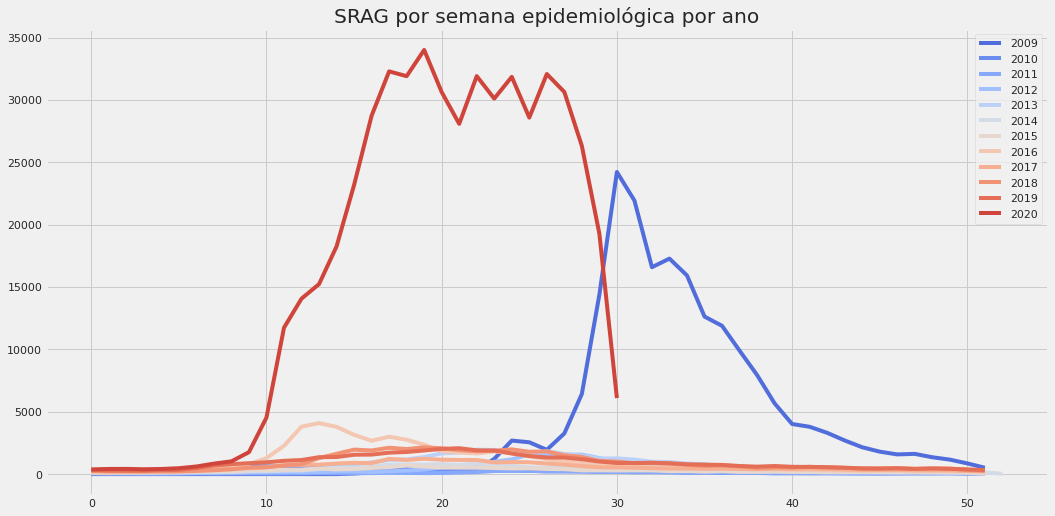

In [14]:
palette = sns.color_palette("coolwarm", len(df_srag.columns))
ax = sns.lineplot(data=df_srag, palette=palette, dashes=False)
ax.set_title('SRAG por semana epidemiológica por ano')

Uma visão alternativa para esses mesmos dados, que enfatiza a proporção em cada ano.

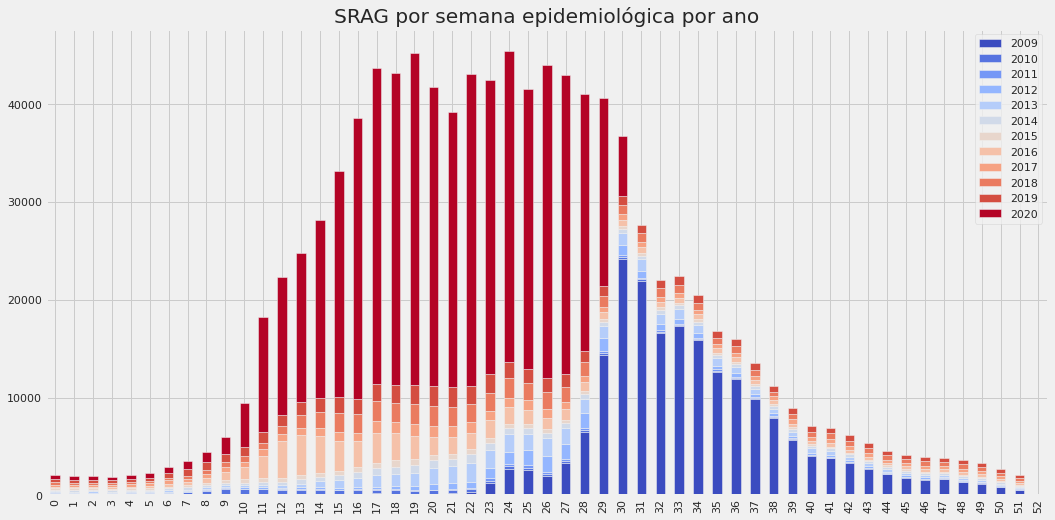

In [15]:
df_srag.plot(kind='bar', stacked=True, colormap='coolwarm', title='SRAG por semana epidemiológica por ano')

Vemos que em 2009 houve um pico bastante anormal, certamente por conta da epidemia de H1N1.

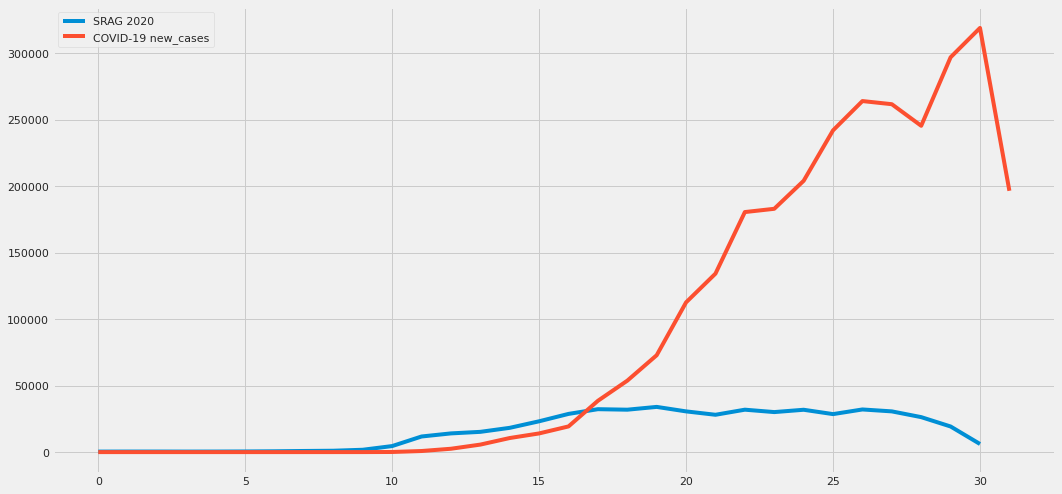

In [16]:
df_comparison =pd.concat([df_srag[2020].rename('SRAG 2020'), 
                          df_covid_target['new_cases'].rename('COVID-19 new_cases').reset_index(drop=True)], axis=1)

ax = sns.lineplot(data=df_comparison, dashes=False)

Qual a magnitude da diferença ao longo do tempo?

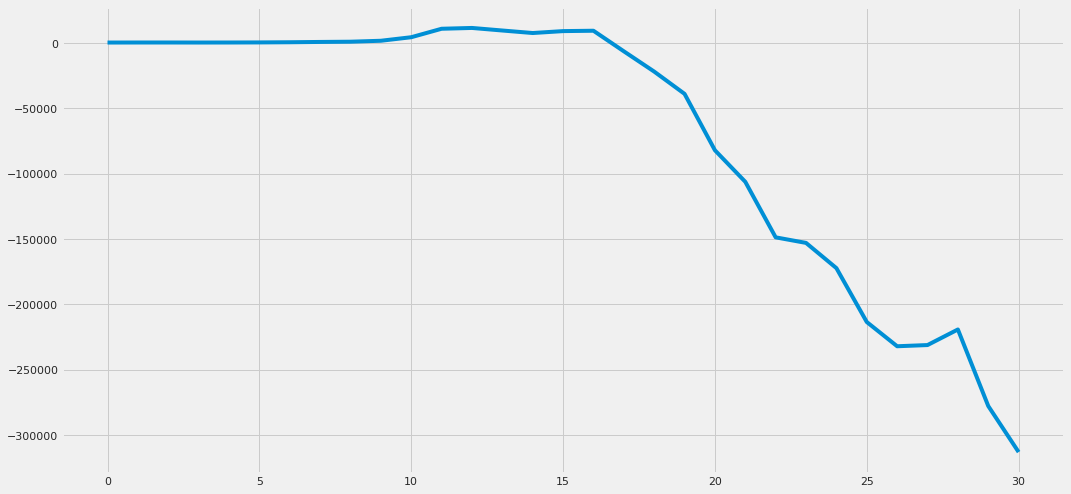

In [17]:
ax = sns.lineplot(data=(df_comparison.iloc[:, 0] - df_comparison.iloc[:, 1]), dashes=False)

## Estimativa de Efeito Causal: CausalImpact

Para estimar o efeito causal supostamente introduzido pela COVID-19, usaremos [a biblioteca CausalImpact](https://github.com/dafiti/causalimpact), a qual exige que os dados sejam dispostos de forma linear no tempo.

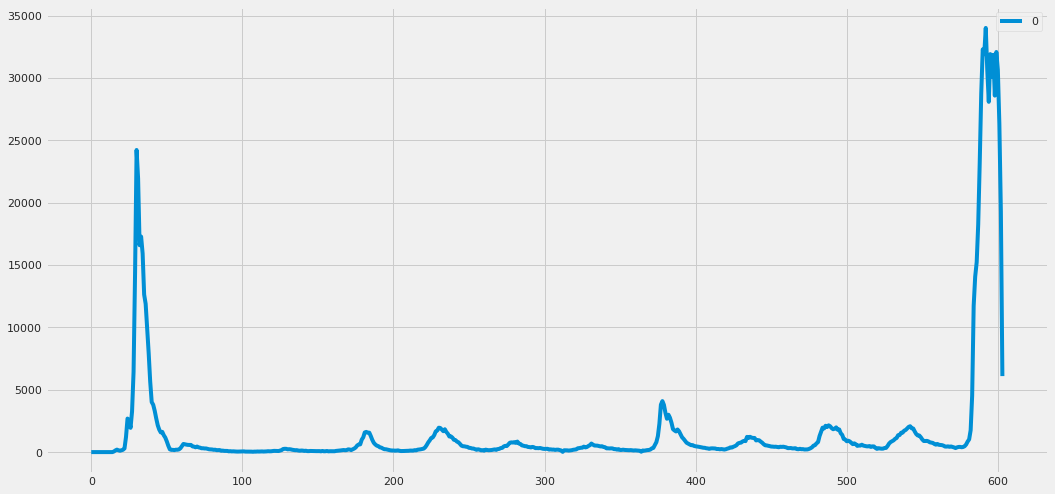

In [18]:
ax = sns.lineplot(data=df_srag_timeline, dashes=False)

Coloquemos a suposta intervenção causal na primeira semana de 2020.

In [19]:
years

array([2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
       2020])

Intervention week: 572
Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    2849.31            37041.0
Prediction (s.d.)         822.28 (618.07)    10689.6 (8034.89)
95% CI                    [-444.87, 1977.91] [-5783.28, 25712.89]

Absolute effect (s.d.)    2027.03 (618.07)   26351.4 (8034.89)
95% CI                    [871.39, 3294.18]  [11328.11, 42824.28]

Relative effect (s.d.)    246.51% (75.17%)   246.51% (75.17%)
95% CI                    [105.97%, 400.62%] [105.97%, 400.62%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 99.7%

For more details run the command: print(impact.summary('report'))


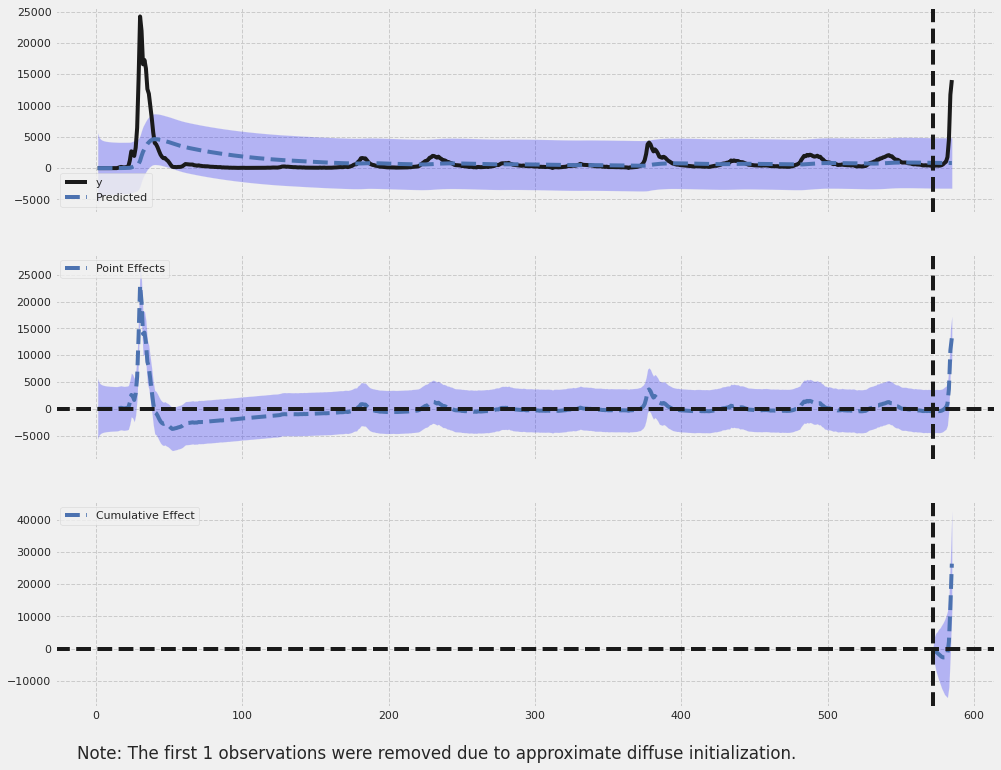

In [20]:
intervention_week = (len(years) - 1) * 52  # all years, except the last one
print("Intervention week:", intervention_week)
pre_period = [0, intervention_week]
post_period = [intervention_week+1, 585]

ci = CausalImpact(df_srag_timeline, pre_period, post_period)
print(ci.summary())
#print(ci.summary(output='report'))
ci.plot()

Podemos então isolar o efeito estimado.

In [21]:
df_causal_effect_1 = ci.inferences.dropna()[['point_effects', 'point_effects_lower', 'point_effects_upper']]
df_causal_effect_1#.head()

,point_effects,point_effects_lower,point_effects_upper
573,-443.277254,-4474.216741,3587.662232
574,-410.277254,-4441.534967,3620.980458
575,-405.277254,-4436.853167,3626.298658
576,-434.277254,-4466.171343,3597.616834
577,-412.277254,-4444.489493,3619.934984
578,-351.277254,-4383.807618,3681.253109
579,-213.277254,-4246.125718,3819.571209
580,18.722746,-4014.443793,4051.889284
581,198.722746,-3834.761843,4232.207334
582,934.722746,-3099.079868,4968.525359


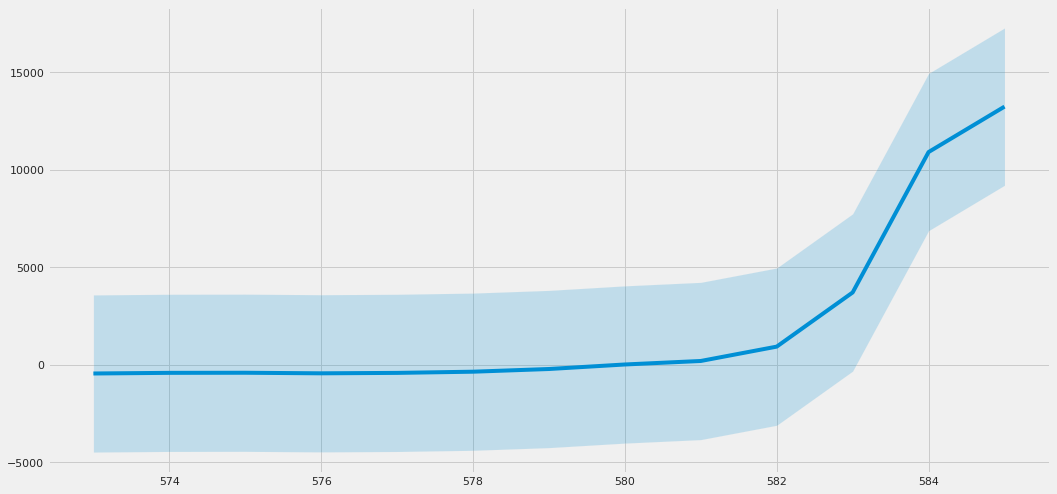

In [22]:
df_causal_effect_1['point_effects'].plot()
plt.fill_between(df_causal_effect_1.index, 
                 df_causal_effect_1[['point_effects_lower', 'point_effects_upper']].values[:, 0],
                df_causal_effect_1[['point_effects_lower', 'point_effects_upper']].values[:, 1],
                alpha=0.2)

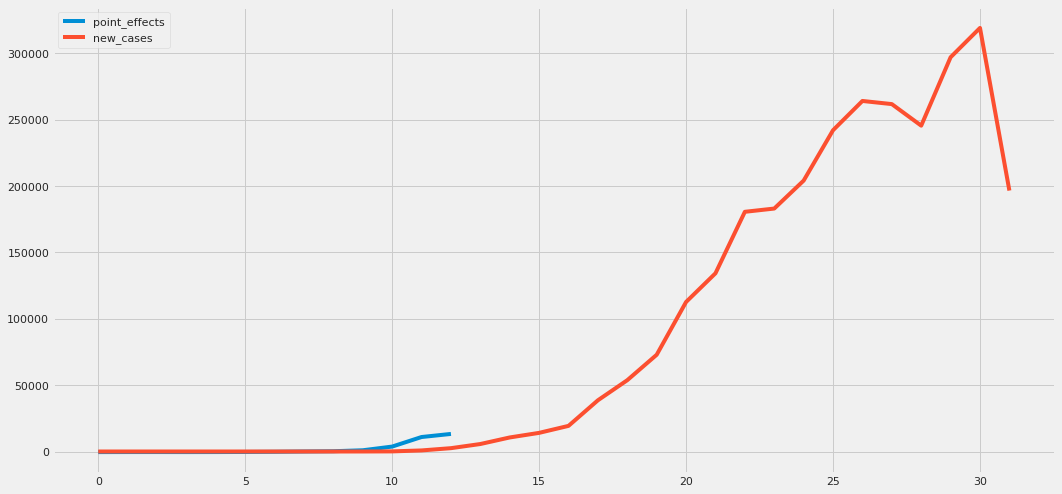

In [23]:
df_comparison_2 =pd.concat([df_causal_effect_1['point_effects'].reset_index(drop=True), 
                            df_covid_target['new_cases'].reset_index(drop=True)], axis=1)

ax = sns.lineplot(data=df_comparison_2, dashes=False)

E calcular a razão entre SRAGs e COVID-19 oficial.

8     198.722746
9      77.893562
10     43.679091
11     13.540599
12      5.269687
dtype: float64

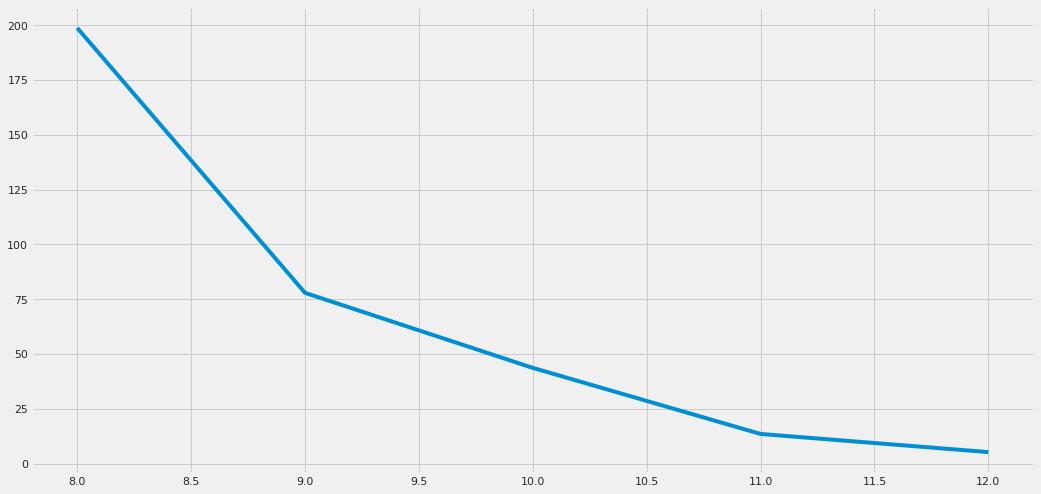

In [24]:
s_a = df_causal_effect_1['point_effects'].reset_index(drop=True)
s_b =  df_covid_target['new_cases'].reset_index(drop=True)
s_ratio_1 = (s_a/s_b)
s_ratio_1 = s_ratio_1[(s_ratio_1 != np.inf) & (s_ratio_1 != -np.inf)].dropna()
ax = sns.lineplot(data=s_ratio_1, 
                  dashes=False)
s_ratio_1

## Estimativa de Efeito Causal: Manual

Façamos agora uma análise manual, supondo-se que as mesmas semanas epidemiológicas em anos diferentes tendem a ter comportamentos semelhantes, salvo em casos excepcionais. Assim, iremos atribuir a diferença (média, mínima, máxima) observada nas semanas do ano corrente a algum fator novo, nomeadamente à COVID-19.

In [25]:
s_srag_cur = df_srag.iloc[:, -1]
df_srag_past = df_srag.iloc[:, :-1]

In [26]:
s_effect_lower = (s_srag_cur - df_srag_past.max(axis=1)).rename('causal_effect_lower')
s_effect_upper = (s_srag_cur - df_srag_past.min(axis=1)).rename('causal_effect_upper')
s_effect_mean = (s_srag_cur - df_srag_past.mean(axis=1)).rename('causal_effect_mean')


df_causal_effect_2 = pd.concat([s_effect_mean, s_effect_lower, s_effect_upper], axis=1) 
df_causal_effect_2.head(15)

,causal_effect_mean,causal_effect_lower,causal_effect_upper
0,227.818182,63.0,379.0
1,268.727273,123.0,412.0
2,275.727273,143.0,417.0
3,249.454545,111.0,388.0
4,256.090909,84.0,410.0
5,307.454545,135.0,471.0
6,399.454545,124.0,609.0
7,595.454545,159.0,841.0
8,711.000000,219.0,1021.0
9,1370.454545,885.0,1757.0


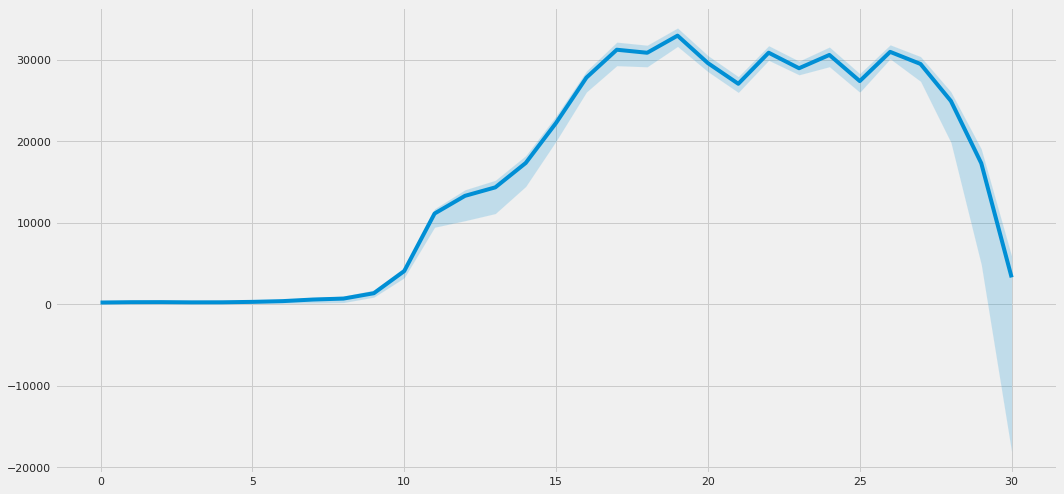

In [27]:
df_causal_effect_2['causal_effect_mean'].plot()
plt.fill_between(df_causal_effect_2.index, 
                 df_causal_effect_2[['causal_effect_lower', 'causal_effect_upper']].values[:, 0],
                 df_causal_effect_2[['causal_effect_lower', 'causal_effect_upper']].values[:, 1],
                 alpha=0.2)

8     711.000000
9     114.204545
10     48.069519
11     13.832055
12      5.299714
13      2.546809
14      1.639594
15      1.585543
16      1.441149
17      0.809700
18      0.574595
19      0.452395
20      0.262786
21      0.201620
22      0.171016
23      0.158311
24      0.149976
25      0.113202
26      0.117331
27      0.112721
28      0.101673
29      0.058312
30      0.010370
dtype: float64

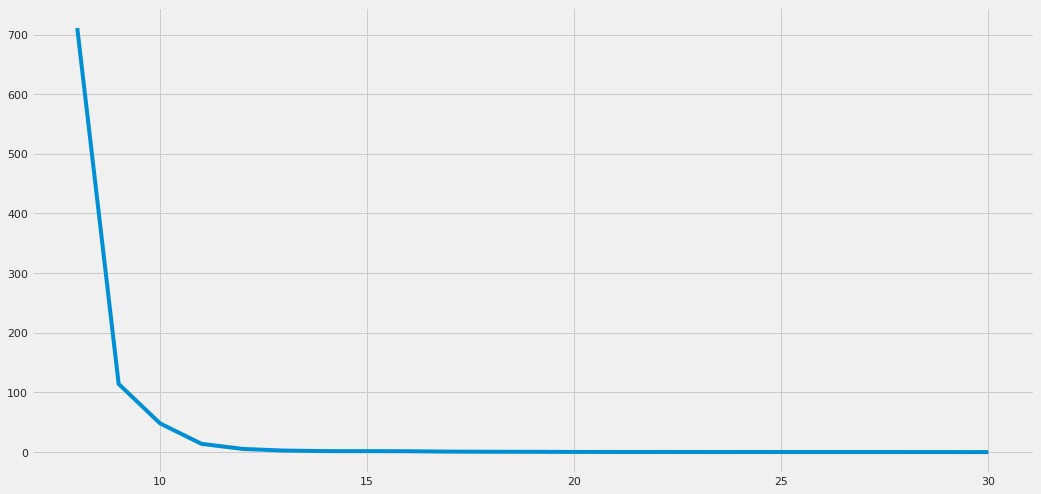

In [28]:
s_a = df_causal_effect_2['causal_effect_mean'].reset_index(drop=True)
s_b =  df_covid_target['new_cases'].reset_index(drop=True)

s_ratio_2 = (s_a/s_b)

s_ratio_2 = s_ratio_2[(s_ratio_2 != np.inf) & (s_ratio_2 != -np.inf)].dropna()
ax = sns.lineplot(data=s_ratio_2, 
                  dashes=False)
s_ratio_2

Os resultados dessa última estimativa de efeito causal parecem mais confiáveis, então a tomaremos como base para a conclusão deste estudo.

In [29]:
s_ratio = s_ratio_2

## Conclusão

Nota-se grande discrepância entre casos usuais de SRAG e casos reportados. Atribuimos assim os casos adicionais à COVID-19. Alguns outros ajustes são necessários para obtermos multiplicadores de ajuste adequados:

  - Note-se ainda que os casos de SRAG reportados referem-se a hospitalizações, que são apenas uma parte dos casos totais esperados de COVID-19. Portanto, para se estimar os casos totais de COVID-19, devemos ainda ajustar a estimativa de hospitalizados de acordo com a probabilidade de ser hospitalizado dado que se tem COVID-19. 
  - Usamos apenas dados considerados já confiáveis. Isso tipicamente exige que desconsideremos algumas semanas mais recentes (variável `min_trustworthy_week`), cujos valores ainda estão sujeitos a grandes mudanças à lentidão com a qual a base de SRAG é atualizada.
  - Supomos que o multiplicador de ajuste nunca pode ser menor do que 1.0, posto que queremos contemplar ao menos os casos reportados.

In [30]:
# Combination of hospitalization rates per age found in 
#
#    https://www.thelancet.com/journals/laninf/article/PIIS1473-3099(20)30243-7/fulltext
# with demographic data found in
# 
#    https://censo2010.ibge.gov.br/sinopse/index.php?dados=12
#
p_hospitalization = (0.037+0.04)*0.0 + (0.046+0.045)*0.000408 + (0.045+0.044)*0.0105 + (0.04+0.35)*0.0343 + (0.033+0.030)*0.0425 +\
                    (0.025+0.02)*0.0816 + (0.016+0.012)*0.118 + (0.009+0.006)*0.166 + (0.004+0.002+0.001)*0.184   
                     #0.034 #0.2
p_hospitalization

0.027780127999999998

8     25593.834557
9      4111.015812
10     1730.356272
11      497.911854
12      190.773571
13       91.677358
14       59.020384
15       57.074713
16       51.876972
17       29.146719
18       20.683684
19       16.284857
20        9.459513
21        7.257706
22        6.156058
23        5.698720
24        5.698720
25        5.698720
26        5.698720
27        5.698720
28        5.698720
29        5.698720
30        5.698720
Name: SRAG_adjustment_multiplier, dtype: float64

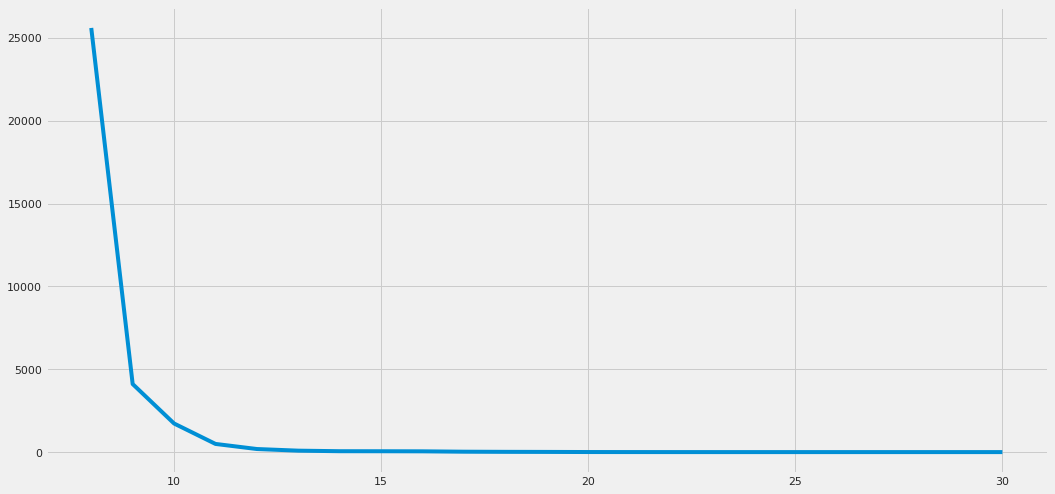

In [31]:
s_adjustment_multipler = s_ratio[s_ratio > 0] / p_hospitalization
s_adjustment_multipler = s_adjustment_multipler.rename('SRAG_adjustment_multiplier')

# we use only the estimates that are trustworthy
s_adjustment_multipler.loc[min_trustworthy_week+1:] = s_adjustment_multipler.loc[min_trustworthy_week]


# we assume that data can never be less than the original estimate
s_adjustment_multipler[s_adjustment_multipler < 1.0] = 1.0

ax = sns.lineplot(data=s_adjustment_multipler, 
                  dashes=False)


s_adjustment_multipler

Vemos assim que as diferenças estimadas são bastante expressivas, o que deve ter impacto na previsão da dinâmica epidemiológica.

Salvemos esses multiplicadores de ajuste para uso posterior. Por conveniência, vamos diarizar esses valores.

In [32]:
weeks = range(0, s_adjustment_multipler.index[-1])

In [33]:
df_daily_adjustment_multipler = \
    df_covid_target\
        .reset_index()\
        .merge(s_adjustment_multipler, left_index=True, right_index=True)\
        .set_index('date')\
        .resample('D')\
        .bfill()\
        [['SRAG_adjustment_multiplier']]

df_daily_adjustment_multipler

,SRAG_adjustment_multiplier
date,
2020-02-29,25593.834557
2020-03-01,4111.015812
2020-03-02,4111.015812
2020-03-03,4111.015812
2020-03-04,4111.015812
...,...
2020-07-28,5.698720
2020-07-29,5.698720
2020-07-30,5.698720


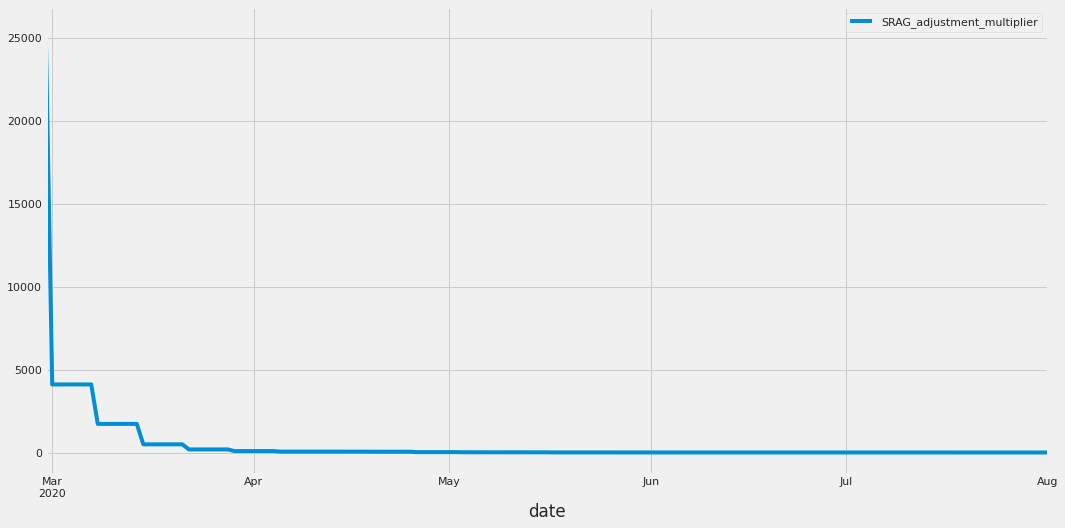

In [34]:
df_daily_adjustment_multipler.plot()

In [35]:
df_daily_adjustment_multipler.to_csv('../results/srag_adjustment_multipliers.brazil.csv')